In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set_palette('Set2')
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, FunctionTransformer, Binarizer
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from scipy.sparse import csr_matrix, hstack

import lightgbm as lgb

from pdpbox import pdp
import shap
shap.initjs()

import gc

## Preprocessing

### Samples / blanks from tagged data

In [2]:
tagged_data = pd.read_csv('../data/tagged_all.csv', index_col='id')

samples = tagged_data[tagged_data['sample']].drop(['sample'], axis=1)
samples[['ph', 'temperature', 'moisture', 'elevation']] = samples[['ph', 'temperature', 'moisture', 
                                                                   'elevation']].apply(pd.to_numeric)

blanks = tagged_data[tagged_data['sample']==False].drop(['sample'], axis=1)

del tagged_data
gc.collect()

14

In [3]:
samples.head()

,medium,2.00min : 143.065m/z,2.00min : 314.216m/z,2.00min : 118.547m/z,2.00min : 210.112m/z,2.00min : 558.276m/z,2.00min : 472.240m/z,2.00min : 587.303m/z,2.00min : 371.202m/z,2.00min : 709.279m/z,...,14.00min : 1013.039m/z,strain,genus,species,elevation,location,ph,temperature,moisture,soiltype
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,409,Xenorhabdus,stockiae,186,Kaengchetkhaew_National_Park_Phitsanulok_Province,6.8,28,1.0,Loam
243_BC2_01_19840,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,432,Photorhabdus,luminescens,243,Nakhonthai_District_Phitsanulok_Province,6.6,26,1.5,Sandy_Loam
244_BC3_01_19841,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,433,Photorhabdus,luminescens,243,Nakhonthai_District_Phitsanulok_Province,6.8,27,1.0,Sandy_Loam
245_BC4_01_19842,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,434,Photorhabdus,luminescens,255,Nakhonthai_District_Phitsanulok_Province,6.8,27,1.0,Sandy_Loam
246_BC5_01_19844,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,435,Xenorhabdus,stockiae,220,Nakhonthai_District_Phitsanulok_Province,6.4,26,3.0,Loam


### Location to district level

In [4]:
# Previous step to remove duplicates and some unwanted characters before splitting

samples.location = samples.location.apply(lambda loc: loc.lower().replace('-district_', '-district').replace('chattakan','chattrakan').replace('__', '_'))
samples.location = samples.location.apply(lambda loc: loc if loc.find('-district') < 0 else loc[loc.find('-district')+len('-district'):])

In [5]:
samples['district'] = samples['location'].apply(lambda loc: loc[:loc.find('national_park_')+len('national_park')] 
                                                if loc.find('district_') < 0 else loc[:loc.find('_district_')])
samples['district'] = samples['district'].apply(lambda district: district[district.rfind('_')+1:] 
                                                if district.find('park_') > 0 else district)

samples['province'] = samples['location'].apply(lambda loc: loc[loc.find('national_park_')
                                                                +len('national_park_'):].replace('_province', '') 
                                                if loc.find('district_') < 0 
                                                else loc[loc.find('district_')+len('district_'):].replace('_province', '').replace('_provinces', ''))

In [6]:
samples.head()

,medium,2.00min : 143.065m/z,2.00min : 314.216m/z,2.00min : 118.547m/z,2.00min : 210.112m/z,2.00min : 558.276m/z,2.00min : 472.240m/z,2.00min : 587.303m/z,2.00min : 371.202m/z,2.00min : 709.279m/z,...,genus,species,elevation,location,ph,temperature,moisture,soiltype,district,province
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Xenorhabdus,stockiae,186,kaengchetkhaew_national_park_phitsanulok_province,6.8,28,1.0,Loam,kaengchetkhaew_national_park,phitsanulok
243_BC2_01_19840,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Photorhabdus,luminescens,243,nakhonthai_district_phitsanulok_province,6.6,26,1.5,Sandy_Loam,nakhonthai,phitsanulok
244_BC3_01_19841,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Photorhabdus,luminescens,243,nakhonthai_district_phitsanulok_province,6.8,27,1.0,Sandy_Loam,nakhonthai,phitsanulok
245_BC4_01_19842,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Photorhabdus,luminescens,255,nakhonthai_district_phitsanulok_province,6.8,27,1.0,Sandy_Loam,nakhonthai,phitsanulok
246_BC5_01_19844,SF900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Xenorhabdus,stockiae,220,nakhonthai_district_phitsanulok_province,6.4,26,3.0,Loam,nakhonthai,phitsanulok


### Visualising the distribution w/r/t metadata

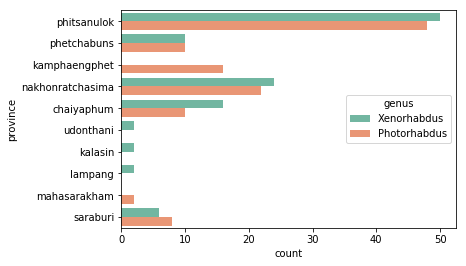

In [7]:
sns.countplot(y='province', data=samples, hue='genus')

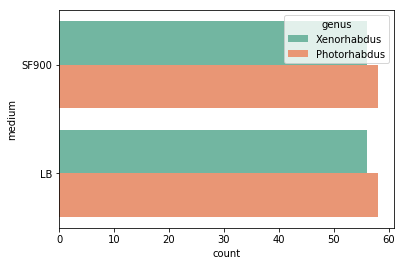

In [8]:
sns.countplot(y='medium', data=samples, hue='genus')

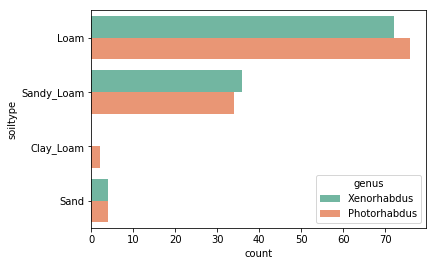

In [9]:
sns.countplot(y='soiltype', data=samples, hue='genus');

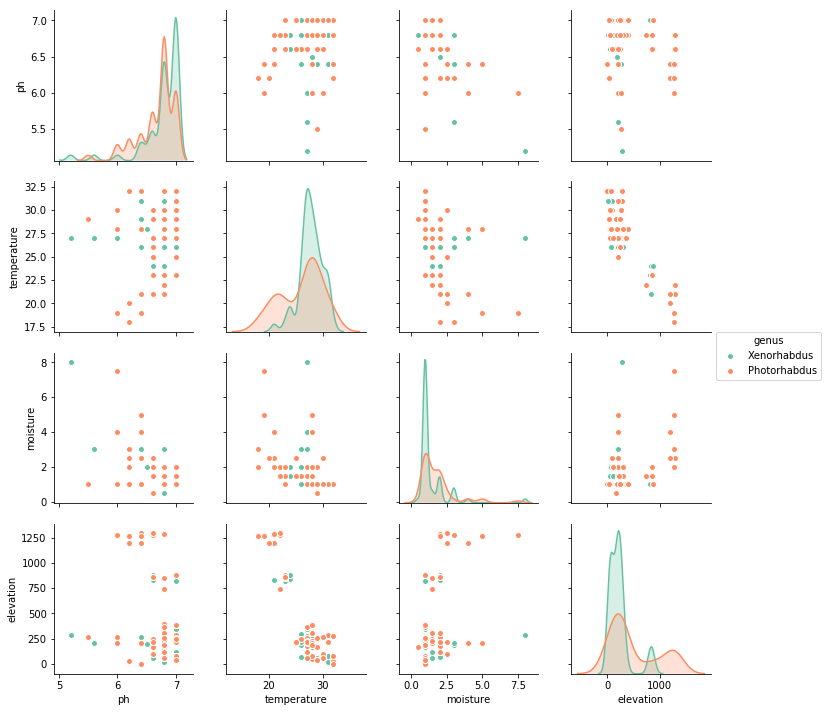

In [10]:
sns.pairplot(samples, vars=['ph', 'temperature', 'moisture', 'elevation'], hue='genus', diag_kind='kde',
             diag_kws=dict(shade=True))

### One-hot-encoding of metadata

In [11]:
media = pd.get_dummies(samples.medium)
districts = pd.get_dummies(samples.district)
provinces = pd.get_dummies(samples.province)
soils = pd.get_dummies(samples.soiltype)

### Target variable: 0 = Photorhabdus, 1 = Xenorhabdus

In [12]:
target = samples.genus

le = LabelEncoder()

y = le.fit_transform(target)

### Feature matrix

In [13]:
features = pd.concat([samples.drop(['genus', 'strain', 'medium', 'soiltype', 'species', 'location', 'district', 
                                    'province'], axis=1), media, soils, districts, provinces], axis=1)

del media, districts, provinces, soils
gc.collect()

2655

In [14]:
features.head()

,2.00min : 143.065m/z,2.00min : 314.216m/z,2.00min : 118.547m/z,2.00min : 210.112m/z,2.00min : 558.276m/z,2.00min : 472.240m/z,2.00min : 587.303m/z,2.00min : 371.202m/z,2.00min : 709.279m/z,2.00min : 481.156m/z,...,chaiyaphum,kalasin,kamphaengphet,lampang,mahasarakham,nakhonratchasima,phetchabuns,phitsanulok,saraburi,udonthani
id,,,,,,,,,,,,,,,,,,,,,
97_GB4_01_19789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
243_BC2_01_19840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
244_BC3_01_19841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
245_BC4_01_19842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
246_BC5_01_19844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


### Peaks in log scale

In [15]:
features[features.columns[:np.argwhere(features.columns == 'elevation')[0,0]]] = features[features.columns[:np.argwhere(features.columns == 'elevation')[0,0]]].apply(np.log1p)

## Training a gradient boosting classifier

### On all columns of the data

In [17]:
CV = LeaveOneOut()

n_splits = CV.get_n_splits(features)

accuracies = np.array([])

importance_list = np.zeros(features.shape[1])
shap_values = np.zeros((features.shape[0],features.shape[1]+1))

for train_index, test_index in CV.split(features):
    
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    bst = lgb.LGBMClassifier(n_estimators=2000, learning_rate=0.01, objective='binary')
    
    bst.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    probs = bst.predict_proba(X_test, num_iteration=bst.best_iteration_)[:,1]
    classes = np.heaviside(probs - 0.5, 1).astype(int)
    
    accuracies = np.append(accuracies, accuracy_score(y_test, classes))
    
    importance_list += bst.booster_.feature_importance(importance_type='gain')/n_splits
    shap_values += shap.TreeExplainer(bst.booster_).shap_values(features)/n_splits

In [18]:
print('mean accuracy: %f' %np.mean(accuracies))

mean accuracy: 0.982456


#### Feature importances

##### 1. Gain from the model

In [19]:
importances = pd.DataFrame({'feature': features.columns[np.argwhere(importance_list > 0)[:,0]], 
                                'importance': importance_list[np.argwhere(importance_list > 0)[:,0]]})

importances = importances.sort_values(by='importance', ascending=False)[:10]

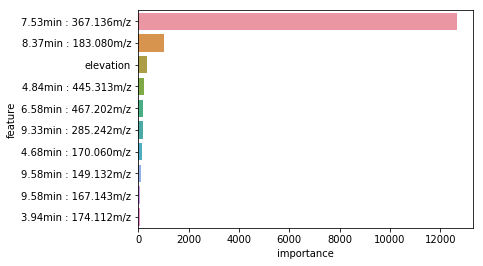

In [20]:
sns.barplot(data=importances, y='feature', x='importance')

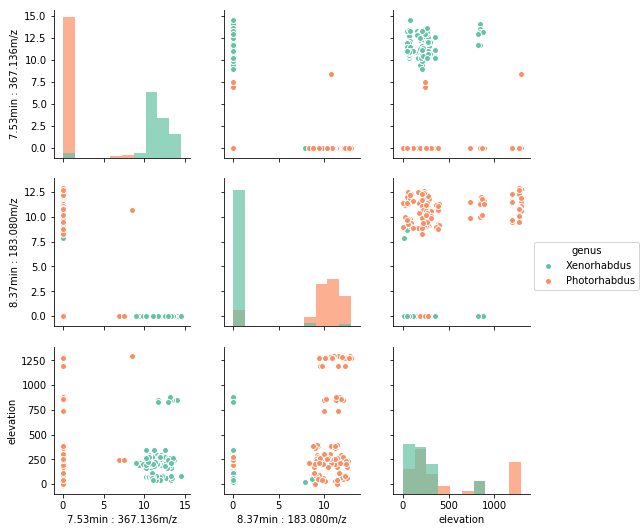

In [21]:
sns.pairplot(pd.concat([features, target], axis=1), vars=importances.feature.iloc[:3],
             hue="genus", diag_kind='hist', diag_kws=dict(histtype='stepfilled', alpha=0.7))

##### 2. SHAP values (model-agnostic importance measure)

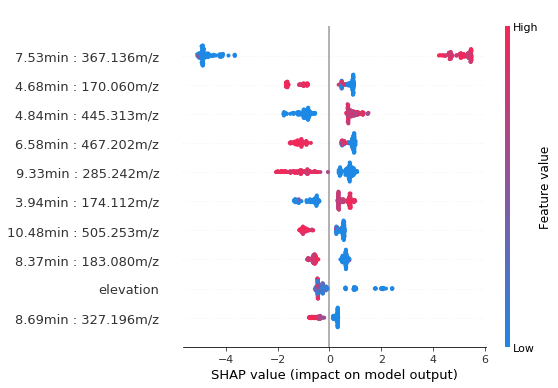

In [22]:
shap.summary_plot(shap_values, features, max_display=10, plot_type='dot')

In [23]:
sorted_columns = np.argsort(np.sum(np.abs(shap_values), axis=0)[:-1])[::-1]

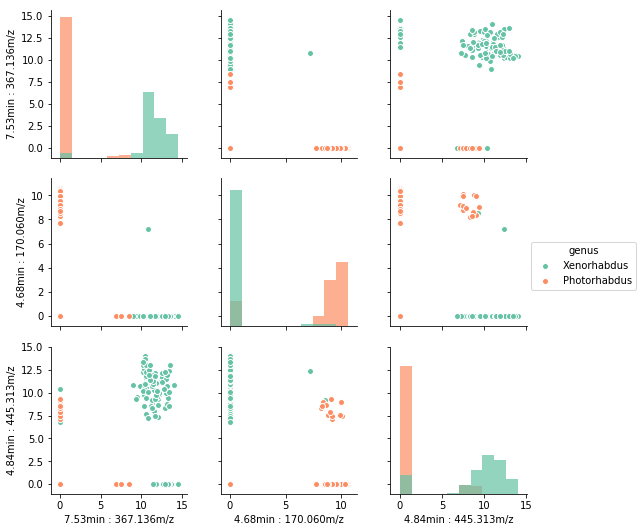

In [24]:
sns.pairplot(pd.concat([features, target], axis=1), vars=features.columns[sorted_columns[:3]],
             hue="genus", diag_kind='hist', diag_kws=dict(histtype='stepfilled', alpha=0.7))

In [25]:
colour_features = target.apply(lambda gen: colours[0] if gen == target.iloc[0] else colours[1])

Text(0.5,0,'log(4.84min : 445.313m/z)')

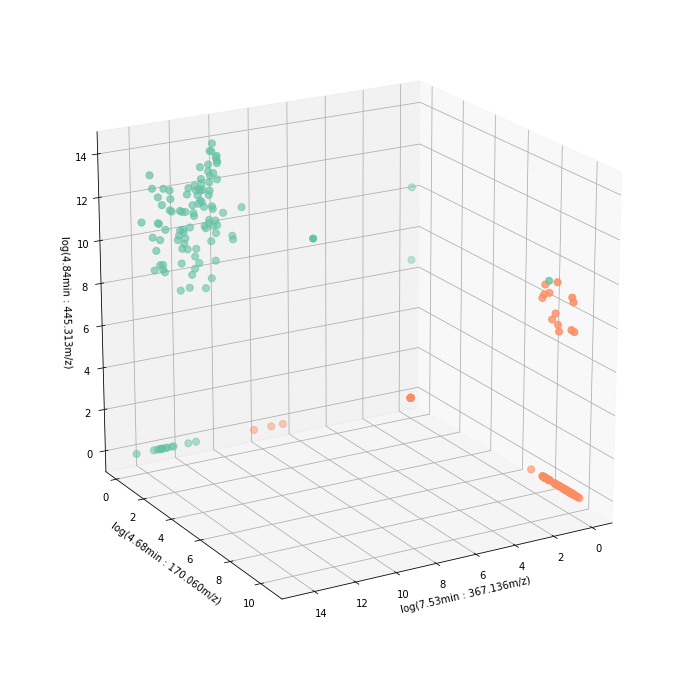

In [26]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': '3d'})

ax.scatter(features[features.columns[sorted_columns[0]]].values, features[features.columns[sorted_columns[1]]].values,
           features[features.columns[sorted_columns[2]]].values, c=colour_features, marker='o', s=50)

ax.view_init(20, 60)

ax.set_xlabel('log('+features.columns[sorted_columns[0]]+')')
ax.set_ylabel('log('+features.columns[sorted_columns[1]]+')')
ax.set_zlabel('log('+features.columns[sorted_columns[2]]+')')

#### Dependence plots

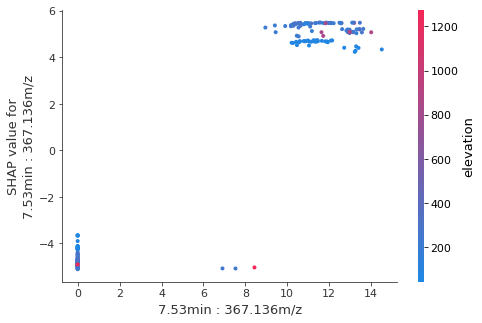

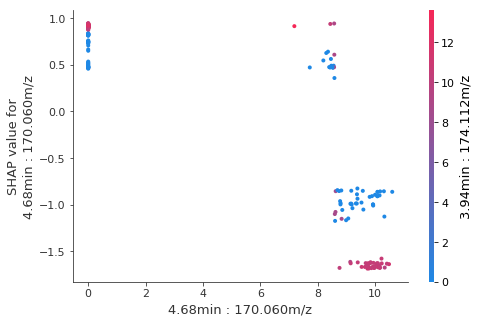

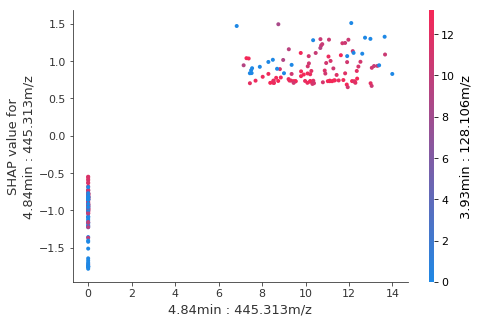

In [27]:
for col in sorted_columns[:3]:
    shap.dependence_plot(features.columns[col], shap_values, features)

### Peaks only, no metadata

In [28]:
peaks = features[features.columns[:np.argwhere(features.columns == 'elevation')[0,0]]]

In [29]:
CV = LeaveOneOut()

n_splits = CV.get_n_splits(peaks)

accuracies_peaks = np.array([])

importance_list_peaks = np.zeros(peaks.shape[1])
shap_values_peaks = np.zeros((peaks.shape[0],peaks.shape[1]+1))

for train_index, test_index in CV.split(peaks):
    X_train, X_test = peaks.values[train_index], peaks.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    bst = lgb.LGBMClassifier(n_estimators=3000, learning_rate=0.01, objective='binary')
    
    bst.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=300, verbose=False)
    
    probs = bst.predict_proba(X_test, num_iteration=bst.best_iteration_)[:,1]
    classes = np.heaviside(probs - 0.5, 1).astype(int)
    
    accuracies_peaks = np.append(accuracies_peaks, accuracy_score(y_test, classes))
    
    importance_list_peaks += bst.booster_.feature_importance(importance_type='gain')/n_splits
    shap_values_peaks += shap.TreeExplainer(bst.booster_).shap_values(peaks)/n_splits

In [30]:
print('mean accuracy: %f' %np.mean(accuracies_peaks))

mean accuracy: 0.982456


#### Feature importances

##### 1. Gain from the model

In [31]:
importances_peaks = pd.DataFrame({'feature': peaks.columns[np.argwhere(importance_list_peaks > 0)[:,0]], 
                       'importance': importance_list_peaks[np.argwhere(importance_list_peaks > 0)[:,0]]})

importances_peaks = importances_peaks.sort_values(by='importance', ascending=False)[:10]

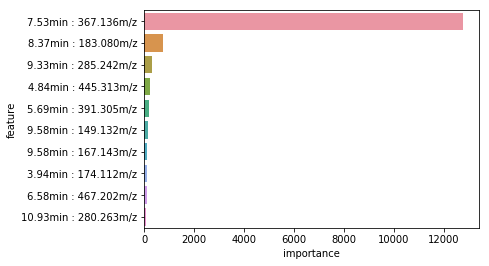

In [32]:
sns.barplot(data=importances_peaks, y='feature', x='importance')

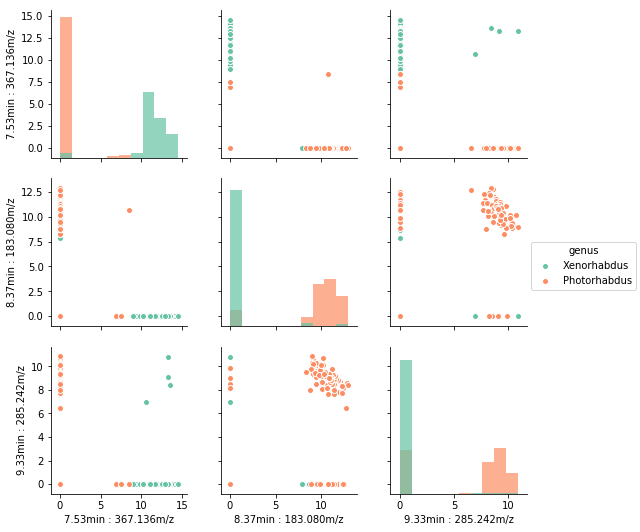

In [33]:
sns.pairplot(pd.concat([peaks, target], axis=1), vars=importances_peaks.feature.iloc[:3],
             hue="genus", diag_kind='hist', diag_kws=dict(histtype='stepfilled', alpha=0.7))

##### 2. SHAP values (model-agnostic importance measure)

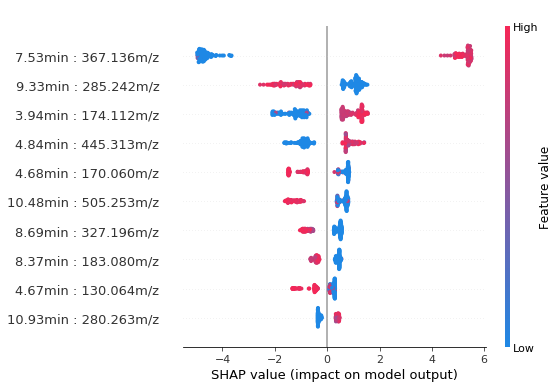

In [51]:
shap.summary_plot(shap_values_peaks, peaks, max_display=10, plot_type='dot')

In [35]:
sorted_columns_peaks = np.argsort(np.sum(np.abs(shap_values_peaks), axis=0)[:-1])[::-1]

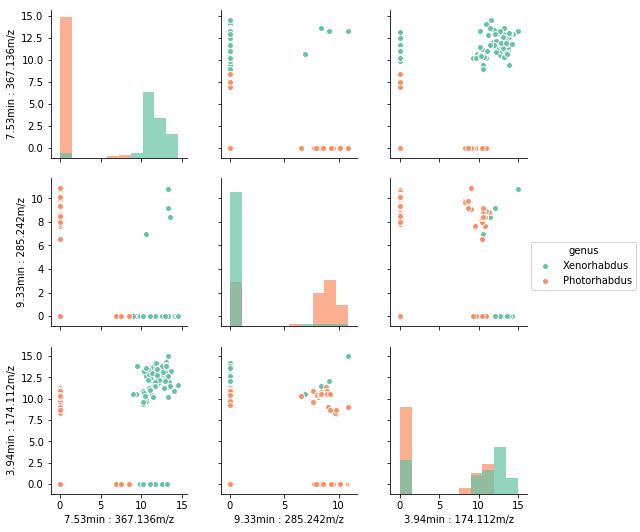

In [36]:
sns.pairplot(pd.concat([peaks, target], axis=1), vars=peaks.columns[sorted_columns_peaks[:3]],
             hue="genus", diag_kind='hist', diag_kws=dict(histtype='stepfilled', alpha=0.7))

Text(0.5,0,'log(3.94min : 174.112m/z)')

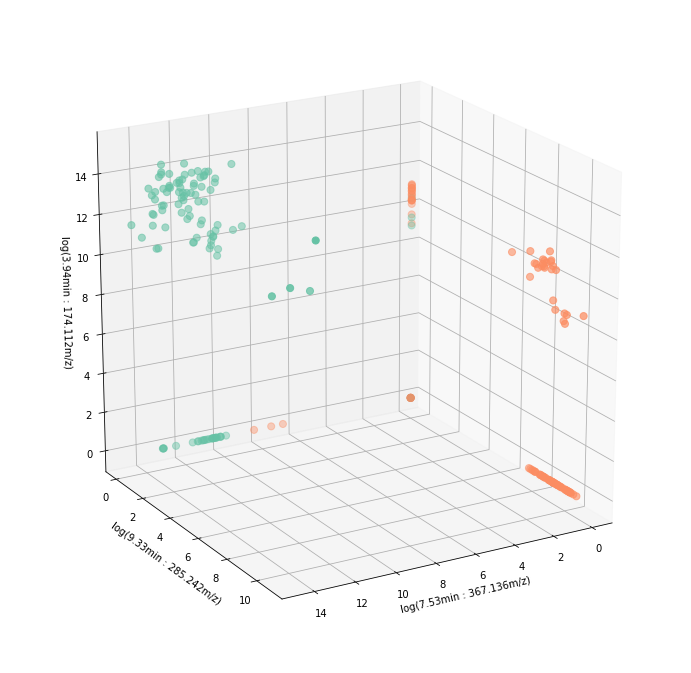

In [37]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': '3d'})

ax.scatter(peaks[peaks.columns[sorted_columns_peaks[0]]].values, 
           peaks[peaks.columns[sorted_columns_peaks[1]]].values,
           peaks[peaks.columns[sorted_columns_peaks[2]]].values, c=colour_features, marker='o', s=50)

ax.view_init(20, 60)

ax.set_xlabel('log('+peaks.columns[sorted_columns_peaks[0]]+')')
ax.set_ylabel('log('+peaks.columns[sorted_columns_peaks[1]]+')')
ax.set_zlabel('log('+peaks.columns[sorted_columns_peaks[2]]+')')

#### Dependence plots

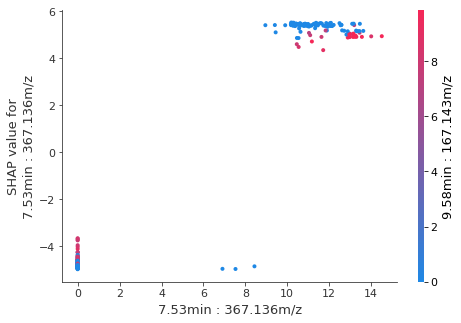

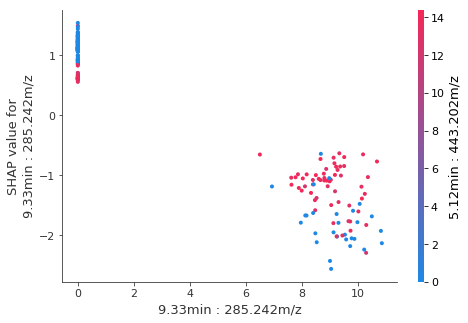

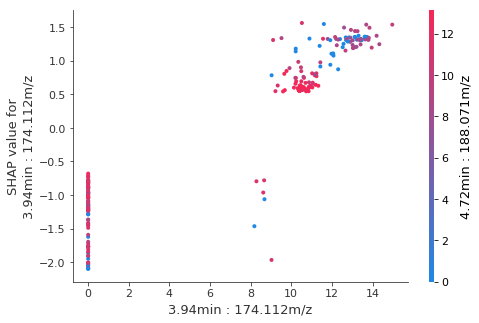

In [38]:
for col in sorted_columns_peaks[:3]:
    shap.dependence_plot(peaks.columns[col], shap_values_peaks, peaks)

### 3 most relevant peaks

In [39]:
relevant = features[features.columns[sorted_columns_peaks[:3]]]

In [40]:
CV = LeaveOneOut()

n_splits = CV.get_n_splits(relevant)

accuracies_relevant = np.array([])

importance_list_relevant = np.zeros(relevant.shape[1])
shap_values_relevant = np.zeros((relevant.shape[0],relevant.shape[1]+1))

for train_index, test_index in CV.split(relevant):
    X_train, X_test = relevant.values[train_index], relevant.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    bst = lgb.LGBMClassifier(n_estimators=3000, learning_rate=0.01, objective='binary')
    
    bst.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=300, verbose=False)
    
    probs = bst.predict_proba(X_test, num_iteration=bst.best_iteration_)[:,1]
    classes = np.heaviside(probs - 0.5, 1).astype(int)
    
    accuracies_relevant = np.append(accuracies_relevant, accuracy_score(y_test, classes))
    
    importance_list_relevant += bst.booster_.feature_importance(importance_type='gain')/n_splits
    shap_values_relevant += shap.TreeExplainer(bst.booster_).shap_values(relevant)/n_splits

In [41]:
print('mean accuracy: %f' %np.mean(accuracies_relevant))

mean accuracy: 0.982456


#### Feature importances

##### 1. Gain from the model

In [42]:
importances_relevant = pd.DataFrame({'feature': relevant.columns[np.argwhere(importance_list_relevant > 0)[:,0]], 
                       'importance': importance_list_relevant[np.argwhere(importance_list_relevant > 0)[:,0]]})

importances_relevant = importances_relevant.sort_values(by='importance', ascending=False)[:10]

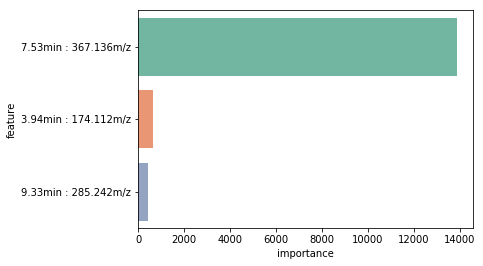

In [43]:
sns.barplot(data=importances_relevant, y='feature', x='importance')

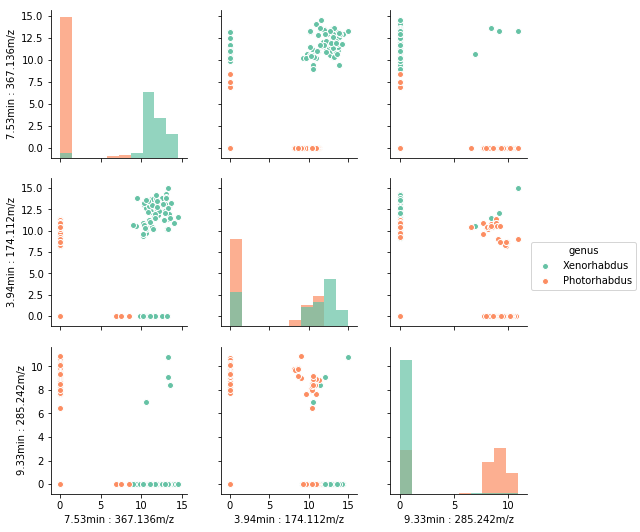

In [44]:
sns.pairplot(pd.concat([relevant, target], axis=1), vars=importances_relevant.feature.iloc[:3],
             hue="genus", diag_kind='hist', diag_kws=dict(histtype='stepfilled', alpha=0.7))

##### 2. SHAP values (model-agnostic importance measure)

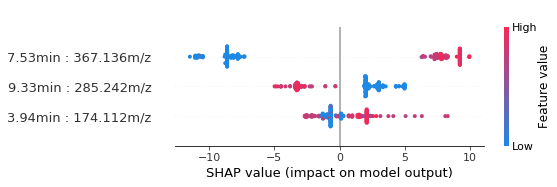

In [45]:
shap.summary_plot(shap_values_relevant, relevant, plot_type='dot')

In [46]:
sorted_columns_relevant = np.argsort(np.sum(np.abs(shap_values_relevant), axis=0)[:-1])[::-1]

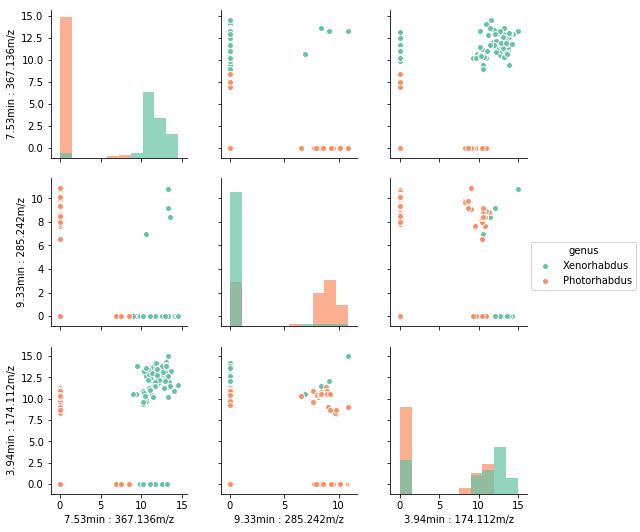

In [47]:
sns.pairplot(pd.concat([relevant, target], axis=1), vars=relevant.columns[sorted_columns_relevant[:3]],
             hue="genus", diag_kind='hist', diag_kws=dict(histtype='stepfilled', alpha=0.7))

Text(0.5,0,'log(3.94min : 174.112m/z)')

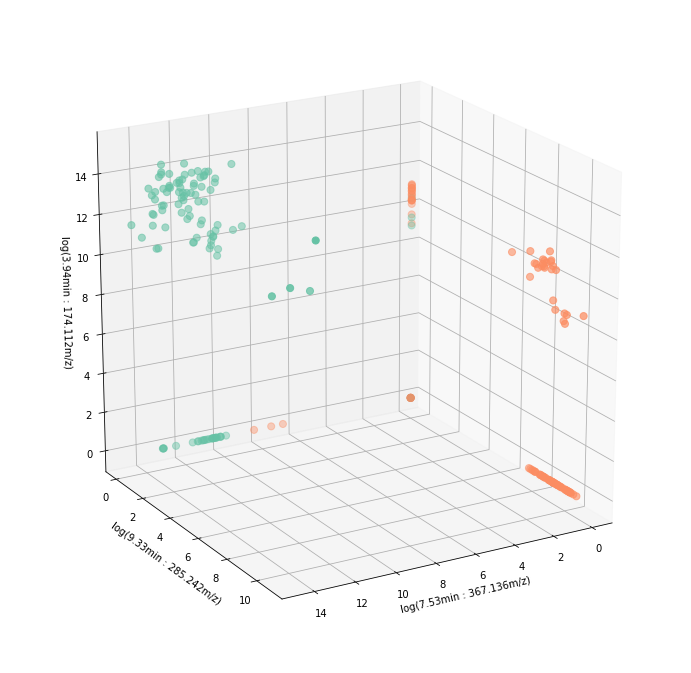

In [48]:
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': '3d'})

ax.scatter(relevant[relevant.columns[sorted_columns_relevant[0]]].values, 
           relevant[relevant.columns[sorted_columns_relevant[1]]].values,
           relevant[relevant.columns[sorted_columns_relevant[2]]].values, c=colour_features, marker='o', s=50)

ax.view_init(20, 60)

ax.set_xlabel('log('+relevant.columns[sorted_columns_relevant[0]]+')')
ax.set_ylabel('log('+relevant.columns[sorted_columns_relevant[1]]+')')
ax.set_zlabel('log('+relevant.columns[sorted_columns_relevant[2]]+')')

#### Dependence plots

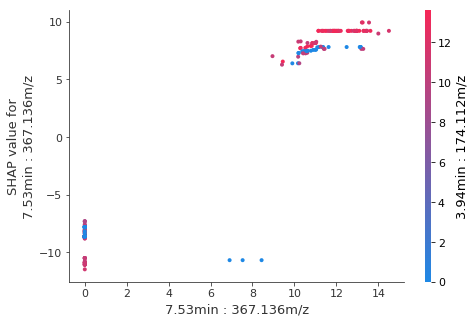

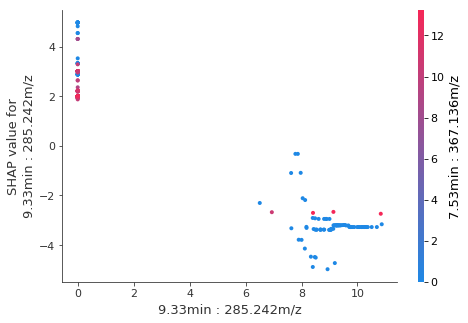

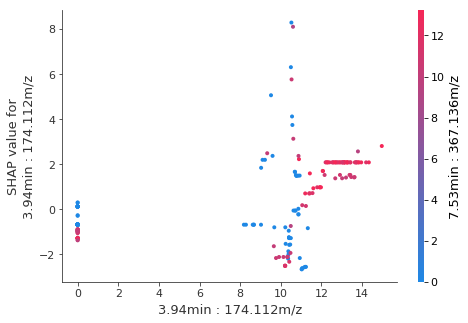

In [49]:
for col in sorted_columns_relevant[:3]:
    shap.dependence_plot(relevant.columns[col], shap_values_relevant, relevant)

#### Local importance

In [95]:
shap.force_plot(shap_values_relevant, relevant)